# Overview
In this notebook we will gain an understanding of how principal component analysis works by gaining some intuition about how eigenvalues and eigenvectors work. We will do our best to avoid complicated mathematical equations until we have established a basic understandsing. This notebook will not explain the complete PCA process but instead establishes a foundational prerequisite understanding.

This notebook assumes you have an understanding of the following concepts:
- Matrix Algebra
- Basic Statistics (Mean, Variance, Covariance)
- Normalization (Standardization)
- Regression analysis (Ordinary Least Squares)

**If you have not yet done so, consider reading the prerequisite material listed in the [README](README.md).**

# 1. Generate Two Normal Random Variables
Rather than load an actual data set we will be working with manufactured data. We are dealing with a lot of theoretical concepts and we will want to be able to intentionally select and contrive various circomstances to facilitate our exploration of the concepts.

In [3]:
# Import python libraries used in this notebook
import numpy
import pandas
from matplotlib import pyplot

In [111]:
# The seed needs to be set in the same frame as the random call...
# I do not know why but there you go
numpy.random.seed(42)
X1 = numpy.random.randn(100)
X2 = numpy.random.randn(100)

Plot them against eachother

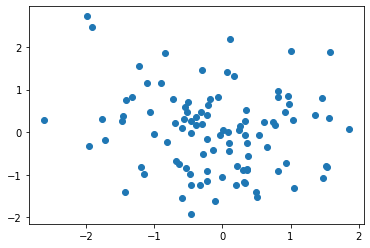

In [112]:
pyplot.scatter(X1, X2);

Notice, the covariance matrix is approximately equal to $I$ the identity matrix:

$$ I = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

In [4]:
print(numpy.cov(X1, X2).round(2))

[[0.79 0.08]
 [0.08 0.88]]


As the number of simulations increaes, the covariance matrix will converge to the identity matrix.

## 1.1. Introduce A Trend In the Data
Working with two normal random variables is too trivial. The system parameters are known and rather simple. Instead, we will transform these random variables by introducing a linear trend into the data. We can induce this linear pattern by multiplying by a new covariance matrix.

**Note**: Thinking of the covariance matrix as a transformation is an important but tricky concept we will revisit later in this notebook.

We can leverage matrix algebra to introduce the trend. Specifically we will multiply our data $X$ by a covariance matrix $\Sigma$ which will allow us to increase the variance in a single dimension or pair of dimensions. The resulting matrix $A$ will thus yield a new covariance scaled proportionately by the $\Sigma$ matrix.

We can write this in matrix form as:

$$ A = X \Sigma $$

### 1.1.1. An Example With No Covariance
In this example, we multiply by a covarianc matrix with zeros in the non-diagonal spaces. The idea being that we will introduce variance into the X and Y axis, but not simultaneously. In this case we will effectively multiiply every element in $X_1$ by 5.

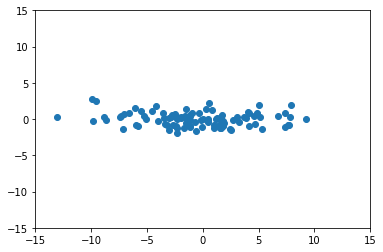

In [126]:
Sigma = [[5, 0],
         [0, 1]]

A = numpy.column_stack((X1, X2))
X = A @ Sigma

fig, ax = pyplot.subplots()
ax.scatter(X[:, 0], X[:, 1]);
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15]);

We can see above that the data is stretched along the X axis but not the y axis.

We can confirm the data was stretched by the matrix as folows:

In [131]:
all(numpy.equal(X1 * 5, X[:, 0]))

True

We also notice that it doesnt appear that $X_1$ and $X_2$ do not vary together. There is no linear trend such that $X_1$ grows while $X_2$ grows or one growns while another shrinks.

Mathematically this becomes clear by looking at the covariance matrix. We see the non-diagonals are closer to zero rather than one.

In [77]:
print(numpy.cov(X.T))

[[19.78539199  0.37761265]
 [ 0.37761265  0.87738822]]


While we didn't intend to introduce any co-linearity into the system, it would appear from the resulting covariance matrix that we did. This is because the scale of the data increased (we multiplied by 5).By multiplying by a scalar we did not change the shape of the data, only the average deviation between the data and its mean. Thus the squared deviations have changed.

We can also see that the resulting covariance matrix is not proportional to the transformation matrix. We specified a 5 for $\sigma_X$ but see the result is such that $\sigma_X \approx 19.78$. This is because the equation for the variance is a sub-of-squares an non-trivial.

### 1.1.2. An Example With Covariance
Now that we looked at the simpler case, lets look at another which is slighly more complicated. If we introduce a non zero covariance we can see that the linear trend being induced can span multiple dimensions.

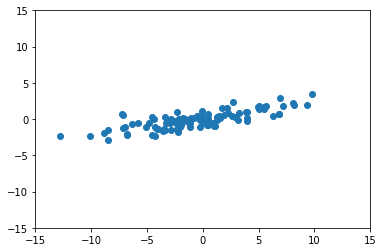

In [132]:
new_cov_2 = [[5, 1],
             [1, 1]]

tmp = A @ new_cov_2

fig, ax = pyplot.subplots()
ax.scatter(tmp[:, 0], tmp[:, 1]);
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15]);

If we wanted a negative linear trend we would have:

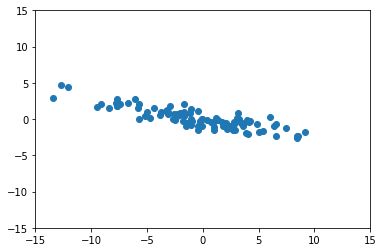

In [133]:
new_cov_2 = [[5, -1],
             [-1, 1]]

tmp = A @ new_cov_2

fig, ax = pyplot.subplots()
ax.scatter(tmp[:, 0], tmp[:, 1]);
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15]);

# 2. Standardize The Data
There are several reasons to standardize the data in the context of PCA. 

The first is that we want to remove bias from the variables of larger scale; The algorithm is based on linear distance; larger variables will have more variance, and thus seem more important. If we normalize our variables, this bias is neutralized (assuming no outliers).

We can compare our scaled data with our original data

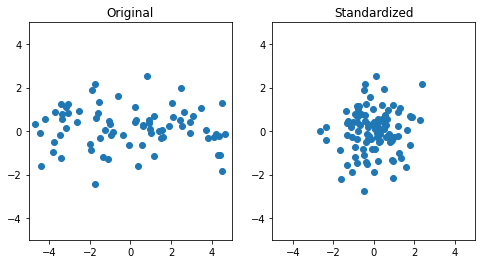

In [45]:
fig, ax = pyplot.subplots(1, 2, figsize=(8,4))
ax[0].scatter(X[0], X[1]);
ax[0].set_xlim([-5, 5])
ax[0].set_ylim([-5, 5]);
ax[0].set_title("Original")
ax[1].scatter(Z[0], Z[1]);
ax[1].set_xlim([-5, 5])
ax[1].set_ylim([-5, 5]);
ax[1].set_title("Standardized");

The next reason is that by standardizing the data set we center the data at the origin. This is a convenient circomstance which makes our calculations much easier.

Additionally, the standardized z-score is a component of the correlation equation. As we will see, PCA can be performed on the correlation matrix or the covariance matrix. If we operate on the former, we simply need to square the matrix to arrive at our staging point.

$$\rho = \frac{1}{n - 1} \left(\frac{X- \bar X}{\sigma_X} \right) \left( \frac{X - \bar X}{\sigma_X} \right)^T = ZZ^T$$

We prove that here:

In [134]:
# Calculate correlation by hand using the formula above
X = pandas.DataFrame(X)
X_bar = X.mean()
X_sigma = X.std()
Z = (X - X_bar) / X_sigma
n = Z.shape[0]
rho_1 = pandas.DataFrame((1/n) * Z.values.T @ Z.values)

# Calculate it using the builtin function
rho_2 = X.corr()

# Ensure they are about equal (accounting for rounding errors)
rho_1.round().equals(rho_2.round())

True

# 3. Decompose The Covariance Matrix

At the heart of PCA is eigen-decomposition where we decompose a square semi-definite positive matrix into a set of eigenvalues $\Lambda = \lambda I$ and eigenvectors $Q$.

As stated earlier, this eigen-decomposition can be performed on the covariance or correlation matrix.

$$ \Sigma = Q \Lambda Q^T $$

We will see that the eigenvectors and eigenvalues indicate the direction of the line of best fit and the magnitude of the variance captured by such best fit line respectively. As we will see, the basic idea is that the eigenvectors will become the new axes (basis) for the data set. This provides a more efficient means of describing  the behavior of the data.

In some literature the eigenvectors are also referred to as "rotation vectors". As we will see, they rotate the basis vector so that the variance is maximized.

## 3.1. Simple Case: No Covariance
When dealing with a data set that does not exibit covariance we should realize that the line of best fit will be pointing in the same direction as the axis pair (basis pair). As such the eigenvectors will be an identity matrix.

In [135]:
Sigma = numpy.array([[5, 0],
                     [0, 1]])

lam, Q = numpy.linalg.eig(Sigma)

print(lam)
print("")
print(Q)

[5. 1.]

[[1. 0.]
 [0. 1.]]


The lambda is also equivalent to the L^2 Norm of the eigenvector.

In [114]:
print(numpy.linalg.norm(Sigma[0], ord=2))
print(numpy.linalg.norm(Sigma[1], ord=2))

5.0
1.0


## 3.2. Non-Simple Case: Non-Zero Covariance
In the non trival case the lambdas will not equal the diagonals of the covariance matrix. The reason is that some of the variance in the system is contained outside the diagonals of the covariance matrix. As such the lambda will be inflated to account for the extra variance being explained by the eigenvector (line of best fit). The variance in the system will equal to the sum of the lambdas, and thus they will can not equal the diagonals of the covariance matrix.

In [136]:
Sigma = [[3, 2],
         [2, 3]]
Sigma = numpy.array(Sigma)

lam, Q = numpy.linalg.eig(Sigma)

print(lam)
print("")
print(Q)

[5. 1.]

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


# 4. Best fit Lines Using Eigen-decomposition

## 4.1. Calculating A List Of Best Fit Using OLS
Ordinary Least Squares is a classical example of fitting a best fit line to the data. 

We can take a shortcut and arrive at the following solution to derive the regression coefficients:

$$ \hat \beta = (X^T X)^{-1} X^T Y $$

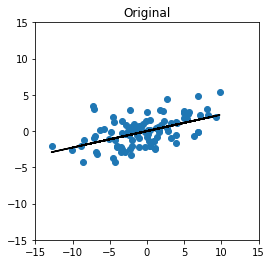

In [176]:
# Create our mock data set
Sigma = [[5, 1],
         [1, 2]]

A = numpy.column_stack((X1, X2))
X = A @ Sigma

# Create a column vector to make the matrix algebra work in numpy
x = X[:, 0][:, None]
y = X[:, 1][:, None]

# Calculate our regression coefficients
beta = numpy.linalg.inv(x.T @ x) @ x.T @ y
beta = beta[0][0]

# Calculate the values for our best fit line
y_hat = beta * x

# Graph the results
fig, ax = pyplot.subplots(1, 1, figsize=(4,4))
ax.scatter(x, y);
ax.plot(x, y_hat, c='black');
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_title("Original");

## 4.2. Calculating Line Of Best Fit Using Eigen-decomposition
We will see how the eigendecomposition can calculate the lines of best fit. As mentioned, the eigenvector will give the direction of the best fit line. The eigenvalue will give the variance captured by the best fit line. Realizing that $\sqrt{\lambda}=\sigma$, we can multiply it by three and realize a segment which will account for 99.7% of the values within the dimension.

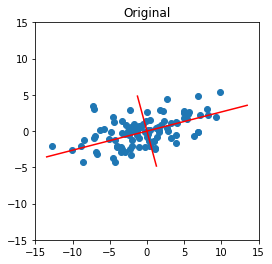

In [177]:
trend = [[5, 1],
         [1, 2]]

A = numpy.column_stack((X1, X2))
X = A @ trend

Sigma = numpy.cov(X.T)
lam, Q = numpy.linalg.eig(Sigma)
Lam = lam * numpy.identity(2)

S = numpy.sqrt(Lam)
T = Q @ S
Y = X @ T

fig, ax = pyplot.subplots(1, 1, figsize=(4,4))
ax.scatter(X[:, 0], X[:, 1]);
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_title("Original")

# Plot the eigenvectors
for eigenvalue, eigenvector in zip(lam, Q.T):
    a = [-3 * numpy.sqrt(eigenvalue) * eigenvector[0], 3 * numpy.sqrt(eigenvalue) * eigenvector[0]]
    b = [-3 * numpy.sqrt(eigenvalue) * eigenvector[1], 3 * numpy.sqrt(eigenvalue) * eigenvector[1]]
    ax.plot(a,b, c="red")

## 4.3. Compare Best Fit Lines
We will next look at the difference between the best fit lines generated using OLS and using eigen-decomposition.

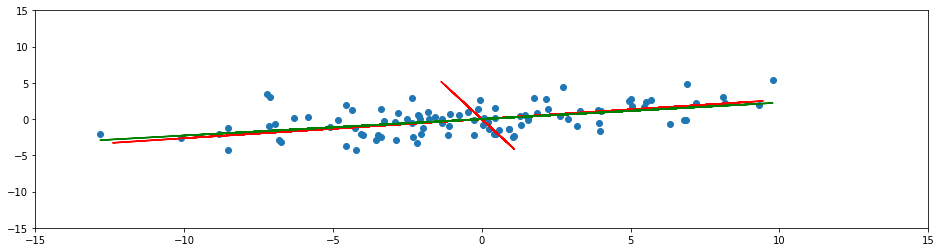

In [185]:
# Create some data
trend = [[5, 1],
         [1, 2]]

A = numpy.column_stack((X1, X2))
X = A @ trend

# Create a column vector
x = X[:, 0][:, None]
y = X[:, 1][:, None]

# Decompose into eigenvalues and eigenvectors
Sigma = numpy.cov(X.T)
lam, Q = numpy.linalg.eig(Sigma)

# Rotate data using eigenvalues and eigenvectors to calculate principal components
q = Q[:, 0]
pc1_x = x * q[0]
pc1_y = x * q[1]

q = Q[:, 1]
pc2_x = y * q[0]
pc2_y = y * q[1]

# Calculate line of best fit
beta = numpy.linalg.inv(x.T @ x) @ x.T @ y
beta = beta[0][0]
beta
y_hat = beta * x

# Plot the principal components and the best fit line
fig, ax = pyplot.subplots(1, 1, figsize=(16,4))
ax.scatter(x, y)
ax.plot(pc1_x, pc1_y, c='r')
ax.plot(pc2_x, pc2_y, c='r')
ax.plot(x, y_hat, c='g');
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15]);

At this point we may be wondering why the red line and green line are not equal. The answer is because the red line (eigenvectors) is maximizing the variance in multiple dimensions simultaneaously while the green line (trival best fit) is only considering a single dimension.

In [194]:
numpy.cov(numpy.column_stack((x, y_hat)).T)

array([[20.34718991,  4.61626657],
       [ 4.61626657,  1.04731499]])

In [195]:
numpy.cov(numpy.column_stack((pc1_x, pc1_y)).T)

array([[19.02084993,  5.02275957],
       [ 5.02275957,  1.32633998]])

# 5. Note On Application To Classification Problems
As we can see, multiplying our eigenvalues by a scalar gives a radius of emperical likelihood. If we plug this radius into the equation for a multidimensional circle we thus have a mechanism for performing binary classification. Things would either be in or out of the circle drawn around the origin.

# 6. Rotating Data
As we mentioned earlier, the eigenvectors will be our new axes. They show us a line of best fit but they also allow us to rotate our data. When we perform a change of basis the calculations will appear as if the data rotated so the best fit lines line up with our trivial axes. We will do that rotation here manually.

## 6.1. Trivial Rotations
In the simplest case, we could subtract our data from the best fit line.

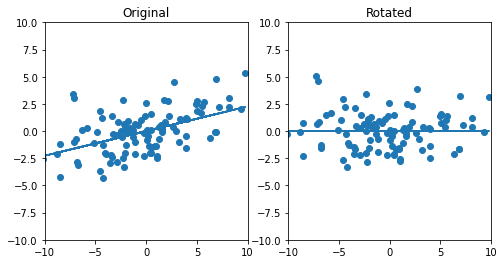

In [142]:
# Create our mock data set
Sigma = [[5, 1],
         [1, 2]]

A = numpy.column_stack((X1, X2))
X = A @ Sigma

# Create a column vector to make the matrix algebra work in numpy
x = X[:, 0][:, None]
y = X[:, 1][:, None]

# Calculate our regression coefficients
beta = numpy.linalg.inv(x.T @ x) @ x.T @ y
beta = beta[0][0]

# Calculate the values for our best fit line
y_hat = beta * x

# Rotate our data 
rotated_y = y - y_hat

# Graph the results
fig, ax = pyplot.subplots(1, 2, figsize=(8,4))
ax[0].scatter(x, y);
ax[0].plot(x, y_hat);
ax[0].set_xlim([-10, 10])
ax[0].set_ylim([-10, 10])
ax[0].set_title("Original")
ax[1].scatter(x, rotated_y)
ax[1].plot(x, [0 for i in x])
ax[1].set_xlim([-10, 10])
ax[1].set_ylim([-10, 10])
ax[1].set_title("Rotated");

## 6.2. Multidimensional Rotations
This is not the ideal rotation because it does not work in multiple dimensions. Instead we can use a transformation similar to the covariance matrix we saw before. We will use a rotation matrix.

$$ R= \begin{bmatrix} 
cos(\theta) & - sin(\theta) \\
sin(\theta) & cos(\theta)
\end{bmatrix} $$

Where $\theta$ is the angle of rotation about the origin.

We can determine the angle of rotation using trigonometry. Given a simple linear regression we have $ y = mx + b $ where $m = \frac{\Delta y}{\Delta x}$. Recalling the acronym SOHCAHTOA we have:

$$ tan(m) = tan(\beta) = tan \left( \frac{\Delta y}{\Delta x} \right) = \theta $$

eigenvectore however provide a built in mechanism for rotating our vectors to the new basis.

Using eigen-decomposition we take the square root of lambda as $S = \sqrt{ \Lambda }$ our equation becomes

$$ \Sigma = QSSQ^T $$

Grouping terms, we can define a linear transformation $T=QS$ such that

$$ \Sigma = TT^T $$

**Note:** These matrices have special properties: $ T^T = (QS)^T = S^TQ^T = SQ^{-1}, Q^{-1}=Q^T $

We can thus rotate the vector $X$ by the transformation $T$ to change our basis.

$$ X_{rot} = XT $$

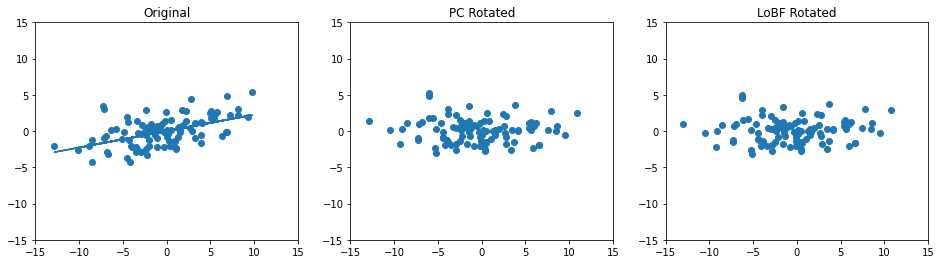

In [173]:
# Create some data
trend = [[5, 1],
         [1, 2]]

A = numpy.column_stack((X1, X2))
X = A @ trend

# Create a column vector
x = X[:, 0][:, None]
y = X[:, 1][:, None]

# Decompose into eigenvalues and eigenvectors
Sigma = numpy.cov(X.T)
lam, Q = numpy.linalg.eig(Sigma)

# Rotate data using eigenvalues and eigenvectors to calculate principal components
q = Q[:, 0]
pc1_x = x * q[0]
pc1_y = x * q[1]

q = Q[:, 1]
pc2_x = y * q[0]
pc2_y = y * q[1]

# Determine the angle of rotation for PCs
pc_dy = pc1_y[0][0] - 0
pc_dx = pc1_x[0][0] - 0
pc_slope = pc_dy / pc_dx
pc_theta = numpy.tan(pc_slope)

# Rotate the data and show the covariance of the new data
pc_R = numpy.array([ [numpy.cos(pc_theta), -numpy.sin(pc_theta)],
                     [numpy.sin(pc_theta),  numpy.cos(pc_theta)]])

pc_RX = X @ pc_R

# Calculate our regression coefficients
beta = numpy.linalg.inv(x.T @ x) @ x.T @ y
beta = beta[0][0]

# Calculate the values for our best fit line
y_hat = beta * x

# Determine the angle of rotation for the LoBF
lobf_theta = numpy.tan(beta)

# Rotate the data
lobf_R = numpy.array([[numpy.cos(lobf_theta), -numpy.sin(lobf_theta)],
                      [numpy.sin(lobf_theta),  numpy.cos(lobf_theta)]])

lobf_RX = X @ lobf_R

fig, ax = pyplot.subplots(1, 3, figsize=(16,4))
ax[0].scatter(X[:, 0], X[:, 1]);
ax[0].plot(x, y_hat);
ax[0].set_xlim([-15, 15])
ax[0].set_ylim([-15, 15])
ax[0].set_title("Original")
ax[1].scatter(pc_RX[:, 0], pc_RX[:, 1])
ax[1].set_xlim([-15, 15])
ax[1].set_ylim([-15, 15])
ax[1].set_title("PC Rotated");
ax[2].scatter(lobf_RX[:, 0], lobf_RX[:, 1])
ax[2].set_xlim([-15, 15])
ax[2].set_ylim([-15, 15])
ax[2].set_title("LoBF Rotated");
